In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
training_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/train.p"
testing_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/test.p"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the training file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [4]:
# Let's create a pandas dataframe to load csv
# The content of csv file is ClassId and the SignName

sign_name_df = pd.read_csv('/content/drive/MyDrive/Dataset/German Traffic Sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [5]:
# Define features and labels for training data
X, y = train['features'], train['labels']

# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [6]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


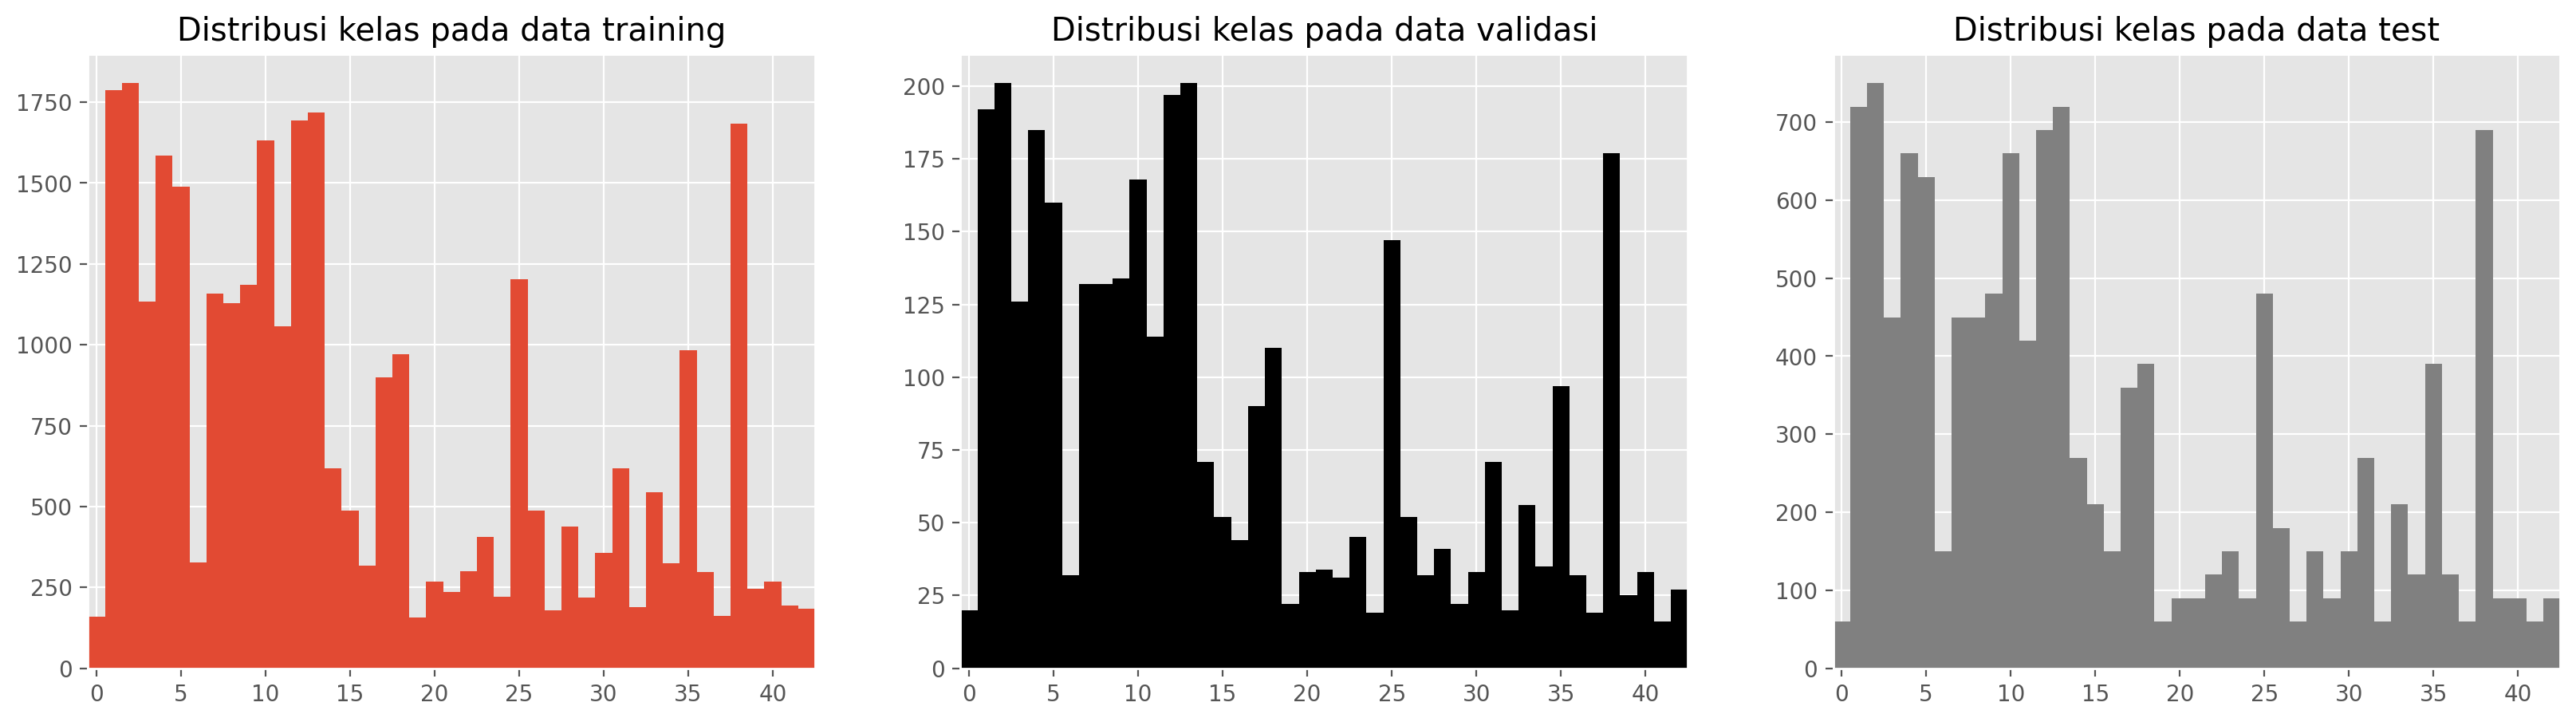

In [7]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [8]:
# Converting the labels into one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

In [11]:
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [12]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 161s 163ms/step - loss: 2.2181 - accuracy: 0.4162 - val_loss: 0.8231 - val_accuracy: 0.7638
Epoch 2/25
979/979 [==============================] - 156s 159ms/step - loss: 0.9096 - accuracy: 0.7166 - val_loss: 0.4385 - val_accuracy: 0.8802
Epoch 3/25
979/979 [==============================] - 156s 159ms/step - loss: 0.6106 - accuracy: 0.8137 - val_loss: 0.2340 - val_accuracy: 0.9385
Epoch 4/25
979/979 [==============================] - 169s 173ms/step - loss: 0.4386 - accuracy: 0.8679 - val_loss: 0.2324 - val_accuracy: 0.9302
Epoch 5/25
979/979 [==============================] - 156s 160ms/step - loss: 0.3668 - accuracy: 0.8905 - val_loss: 0.1147 - val_accuracy: 0.9698
Epoch 6/25
979/979 [==============================] - 153s 157ms/step - loss: 0.3257 - accuracy: 0.9049 - val_loss: 0.1040 - val_accuracy: 0.9690
Epoch 7/25
979/979 [==============================] - 155s 158ms/step - loss: 0.2952 - accuracy: 0.9154 - val_loss: 0.1034 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


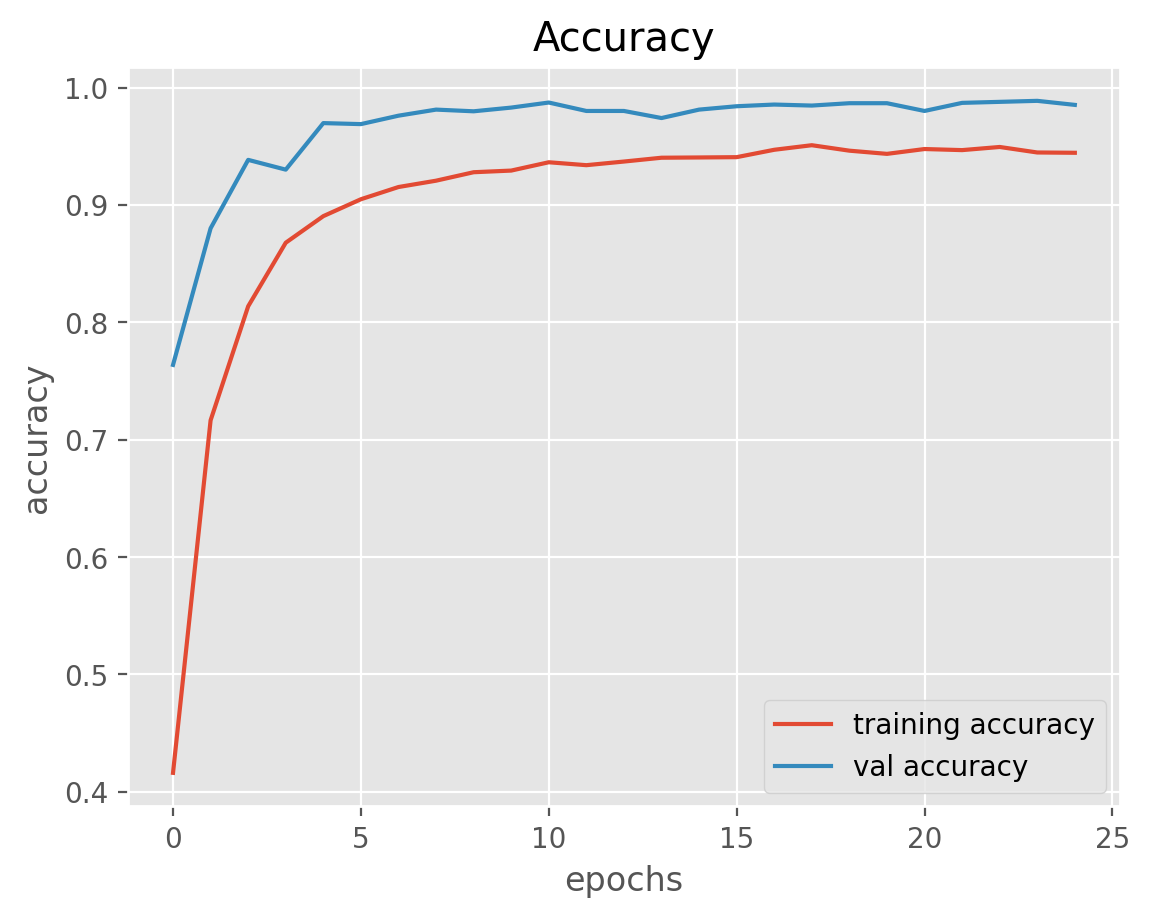

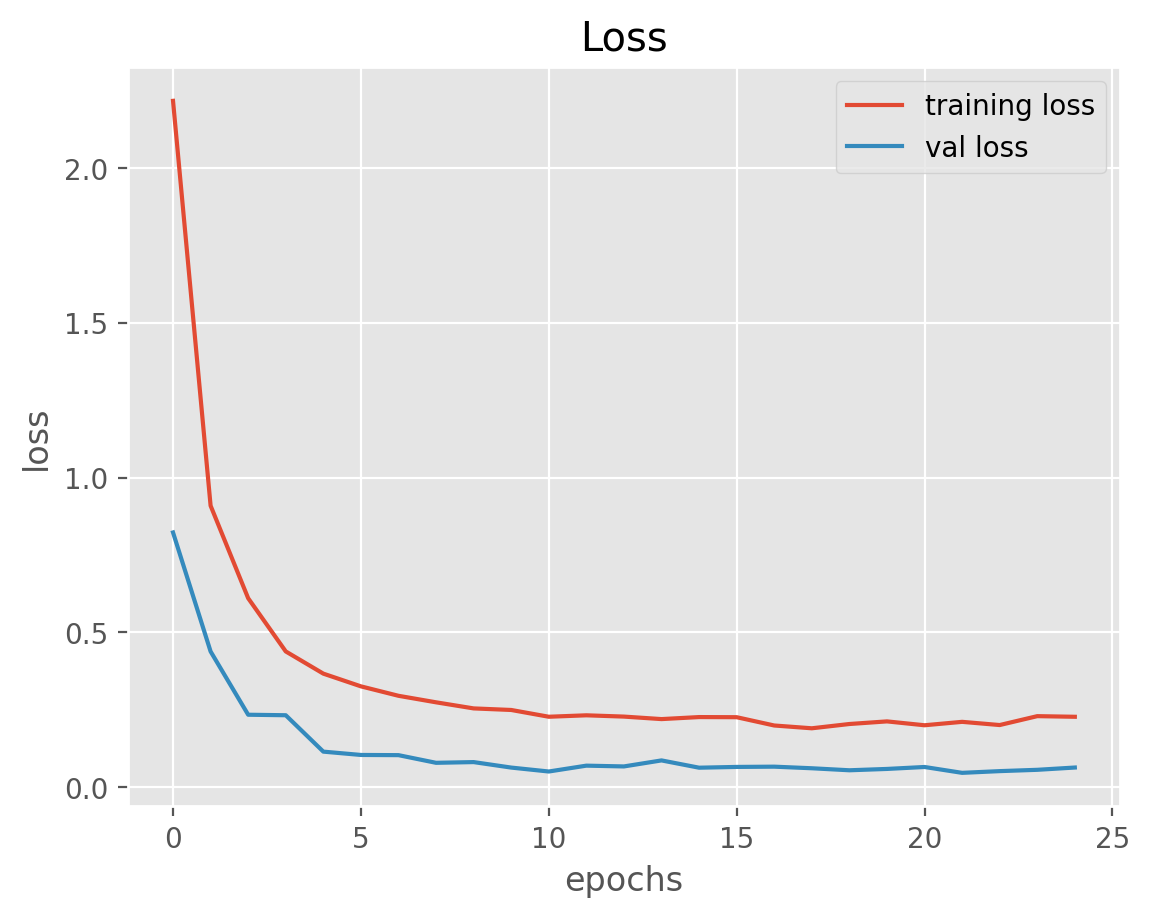

In [15]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 16s 40ms/step


0.9535233570863024

In [17]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.99      0.98      0.98       720
           2       0.98      0.96      0.97       750
           3       0.90      0.95      0.93       450
           4       0.98      0.97      0.97       660
           5       0.91      0.93      0.92       630
           6       1.00      0.71      0.83       150
           7       0.96      0.94      0.95       450
           8       0.93      0.99      0.96       450
           9       0.97      0.94      0.96       480
          10       0.95      0.99      0.97       660
          11       0.83      0.99      0.90       420
          12       0.96      0.99      0.98       690
          13       1.00      0.99      0.99       720
          14       0.99      0.97      0.98       270
          15       0.98      1.00      0.99       210
          16       0.99      0.99      0.99       150
          17       1.00    